##Project objective: 
**Use 3 pretrained models on the same dataset then, save the one with best accuracy.**

### **Prepare Data**
### **I chose flowers data to see which model will give the best accuracy with.**

>**Upload your kaggle.json file to colab and copy api command to get the data.** 

In [1]:
import os, shutil
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 99% 222M/225M [00:01<00:00, 161MB/s]
100% 225M/225M [00:01<00:00, 171MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

In [4]:
os.listdir('/content/flowers')

['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']

**As you can see all the data in one folder called (flowers), now let's use (splitfolder) liberary to split data into train, validation and test.**

In [5]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders
splitfolders.ratio("flowers", output="all_data",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False) # ratio =(train,validation, and test respectivly)

Copying files: 4317 files [00:01, 3777.15 files/s]


In [7]:
os.listdir('/content/all_data/')

['train', 'val', 'test']

In [8]:
base= '/content/all_data'
train_dir = os.path.join(base,'train')
os.listdir(train_dir)

['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']

In [9]:
val_dir = os.path.join(base,'val')
os.listdir(val_dir)

['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']

In [10]:
test_dir = os.path.join(base,'test')
os.listdir(test_dir)

['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']

### **Data Augmentation**


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [12]:
target_shape = (224 , 224)  # all pretrained models I use have this input shape
train_image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      fill_mode='nearest')

train_gen = train_image_gen.flow_from_directory(
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size = target_shape,
                                                     class_mode='sparse')

Found 3019 images belonging to 5 classes.


In [13]:
image_gen = ImageDataGenerator(rescale=1./255)
val_gen = image_gen.flow_from_directory(
                                                     directory=val_dir,
                                                     shuffle=True,
                                                     target_size = target_shape,
                                                     class_mode='sparse')

Found 860 images belonging to 5 classes.


In [14]:
test_gen = image_gen.flow_from_directory(
                                         directory = test_dir,
                                         shuffle = True,
                                         target_size = target_shape,
                                         class_mode = 'sparse')

Found 438 images belonging to 5 classes.


**Show augmented training samples**

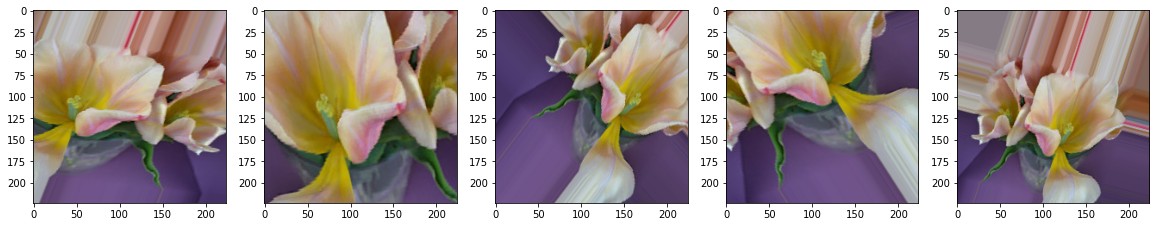

In [15]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)    

### **Model Creation**
**By using feature vector (Transfer Learning) right away**
**I am using:**
1. **MobileNet:** https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
2. **Inception:**https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5
3. **NansNet:** https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5

**To compare them, make epochs and training conditions the same.**


In [15]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

**Note: the varible should be mobilenet insted of imagenet**

In [16]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #you can get it from the link
classes = 5
pretrained_model_without_last_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

imagenet_model = tf.keras.Sequential([
  pretrained_model_without_last_layer,
  tf.keras.layers.Dense(classes)
])

imagenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
imagenet_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
  metrics= [keras.metrics.SparseCategoricalAccuracy()])

In [18]:
epochs = 10 #constant in all models
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) #constant in all models
history = imagenet_model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks= [early_stopping_monitor] 
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10
95/95 [==============================] - 159s 2s/step - loss: 0.8833 - sparse_categorical_accuracy: 0.6678 - val_loss: 0.5006 - val_sparse_categorical_accuracy: 0.8372
Epoch 2/10
95/95 [==============================] - 136s 1s/step - loss: 0.5385 - sparse_categorical_accuracy: 0.8029 - val_loss: 0.4399 - val_sparse_categorical_accuracy: 0.8558
Epoch 3/10
95/95 [==============================] - 157s 2s/step - loss: 0.4844 - sparse_categorical_accuracy: 0.8258 - val_loss: 0.4104 - val_sparse_categorical_accuracy: 0.8558
Epoch 4/10
95/95 [==============================] - 139s 1s/step - loss: 0.4124 - sparse_categorical_accuracy: 0.8513 - val_loss: 0.3774 - val_sparse_categorical_accuracy: 0.8756
Epoch 5/10
95/95 [==============================] - 136s 1s/step - loss: 0.4207 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.3541 - val_sparse_categorical_accuracy: 0.8930
Epoch 6/10
95/95 [==============================] - 136s 1s/step - loss: 0.3795 - sparse_categorical_accu

Comment:
>**Seems more epochs will be better!, but these enough for me due to time**


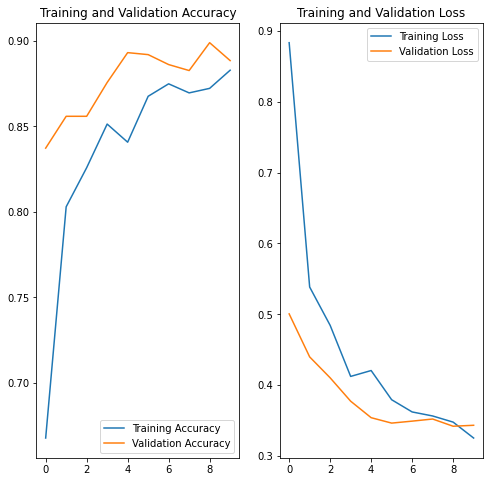

In [19]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
imagenet_model.evaluate(test_gen[0][0].tolist(),test_gen[0][1].astype(int).tolist()) # test_gen[0][1] contains imgs and test_gen[0][1] contains labels 

1/1 [==============================] - 2s 2s/step - loss: 0.3318 - sparse_categorical_accuracy: 0.8750


[0.3318166732788086, 0.875]

In [20]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5" 
pretrained_model_without_last_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

inception_model = tf.keras.Sequential([
  pretrained_model_without_last_layer,
  tf.keras.layers.Dense(classes)
])

inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1024)              10173112  
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 10,178,237
Trainable params: 5,125
Non-trainable params: 10,173,112
_________________________________________________________________


In [21]:
inception_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
  metrics= [keras.metrics.SparseCategoricalAccuracy()])

In [22]:
inception_history = inception_model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks= [early_stopping_monitor] 
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
95/95 [==============================] - 354s 4s/step - loss: 1.0601 - sparse_categorical_accuracy: 0.5992 - val_loss: 0.6923 - val_sparse_categorical_accuracy: 0.7663
Epoch 2/10
95/95 [==============================] - 341s 4s/step - loss: 0.6743 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.5318 - val_sparse_categorical_accuracy: 0.8140
Epoch 3/10
95/95 [==============================] - 354s 4s/step - loss: 0.5767 - sparse_categorical_accuracy: 0.8016 - val_loss: 0.4865 - val_sparse_categorical_accuracy: 0.8314
Epoch 4/10
95/95 [==============================] - 345s 4s/step - loss: 0.5426 - sparse_categorical_accuracy: 0.8109 - val_loss: 0.4363 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/10
95/95 [==============================] - 353s 4s/step - loss: 0.4963 - sparse_categorical_accuracy: 0.8241 - val_loss: 0.4129 - val_sparse_categorical_accuracy: 0.8733
Epoch 6/10
95/95 [==============================] - 340s 4s/step - loss: 0.4856 - sparse_categorical_accu

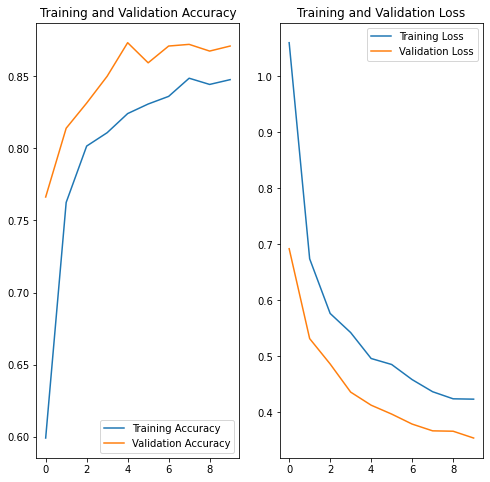

In [28]:
acc = inception_history.history['sparse_categorical_accuracy']
val_acc = inception_history.history['val_sparse_categorical_accuracy']
loss = inception_history.history['loss']
val_loss = inception_history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Comment:
> **less accurate than mobilenet but seems more stable**

In [25]:
inception_model.evaluate(test_gen[0][0].tolist(),test_gen[0][1].astype(int).tolist())

1/1 [==============================] - 3s 3s/step - loss: 0.3304 - sparse_categorical_accuracy: 0.9375


[0.3303976058959961, 0.9375]

**WOW! it gives better accuracy on evaluation.**

In [37]:
feature_extractor_model = "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5" 
pretrained_model_without_last_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

nansnet_model = tf.keras.Sequential([
  pretrained_model_without_last_layer,
  tf.keras.layers.Dense(classes)
])

nansnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1056)              4269716   
                                                                 
 dense_4 (Dense)             (None, 5)                 5285      
                                                                 
Total params: 4,275,001
Trainable params: 5,285
Non-trainable params: 4,269,716
_________________________________________________________________


In [38]:
nansnet_model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
  metrics= [keras.metrics.SparseCategoricalAccuracy()])

In [39]:
nansnet_history = nansnet_model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks= [early_stopping_monitor] 
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
95/95 [==============================] - 360s 3s/step - loss: 0.9848 - sparse_categorical_accuracy: 0.6207 - val_loss: 0.6830 - val_sparse_categorical_accuracy: 0.7558
Epoch 2/10
95/95 [==============================] - 314s 3s/step - loss: 0.6824 - sparse_categorical_accuracy: 0.7473 - val_loss: 0.5613 - val_sparse_categorical_accuracy: 0.8116
Epoch 3/10
95/95 [==============================] - 288s 3s/step - loss: 0.5844 - sparse_categorical_accuracy: 0.7950 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.8140
Epoch 4/10
95/95 [==============================] - 314s 3s/step - loss: 0.5603 - sparse_categorical_accuracy: 0.7989 - val_loss: 0.5013 - val_sparse_categorical_accuracy: 0.8244
Epoch 5/10
95/95 [==============================] - 313s 3s/step - loss: 0.5183 - sparse_categorical_accuracy: 0.8125 - val_loss: 0.4829 - val_sparse_categorical_accuracy: 0.8256
Epoch 6/10
95/95 [==============================] - 314s 3s/step - loss: 0.4991 - sparse_categorical_accu

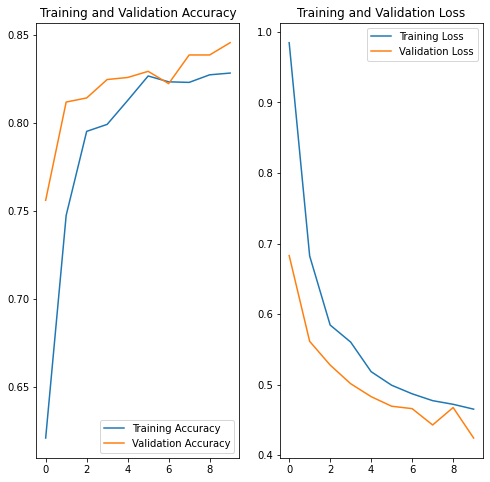

In [40]:
acc = nansnet_history.history['sparse_categorical_accuracy']
val_acc = nansnet_history.history['val_sparse_categorical_accuracy']
loss = nansnet_history.history['loss']
val_loss = nansnet_history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
nansnet_model.evaluate(test_gen[0][0].tolist(),test_gen[0][1].astype(int).tolist())

1/1 [==============================] - 5s 5s/step - loss: 0.3479 - sparse_categorical_accuracy: 0.8750


[0.34791290760040283, 0.875]

### **Conclusion:**
MobileNet is the best one with loss and fit accuracy however, in evaluation it comes in second place after Inception model.

### **Save Models**

In [29]:
from keras.models import save_model
imagenet_model.save("mobilenet_flower_classification.h5")

In [27]:
inception_model.save("inception_flower_classification.h5")